<a href="https://colab.research.google.com/github/AyushAware/Backtrader--Trading-Strategies-Implementation/blob/main/Backtrader_AyushAware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install backtrader


     |████████████████████████████████| 410 kB 4.4 MB/s 


In [4]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from IPython.display import Image
import datetime  
import os.path  
import sys

In [7]:
sys.path.append('/content/gdrive/My Drive/Backtrader/')

In [22]:
import backtrader as bt
from backtrader.indicators import EMA
import datetime
import yfinance as yf
from matplotlib import pyplot as plt

In [19]:
class RSI(bt.Strategy):
	params=(('min_RSI',35),('max_RSI',65),('max_position',10),('look_back_period',14))

	def log(self, txt, dt=None):
		dt = dt or self.datas[0].datetime.date(0)
		print('%s, %s' % (dt.isoformat(), txt))

	def __init__(self):
		# RSI indicator
		self.RSI = bt.indicators.RSI_SMA(self.data.close, period=self.params.look_back_period) 

	def notify_order(self, order):
		if order.status in [order.Submitted, order.Accepted]:
		# Buy/Sell order submitted/accepted to/by broker - Nothing to do
			return

		# Check if an order has been completed
		# Attention: broker could reject order if not enough cash
		if order.status in [order.Completed]:
			if order.isbuy():
				self.log('BUY EXECUTED, %.2f' % order.executed.price)
			elif order.issell():
				self.log('SELL EXECUTED, %.2f' % order.executed.price)

			self.bar_executed = len(self)

		elif order.status in [order.Canceled, order.Margin, order.Rejected]:
			self.log('Order Canceled/Margin/Rejected')

		# Write down: no pending order
		self.order = None

	def next(self):

		# Buy if over sold
		if self.RSI < self.params.min_RSI:
			self.buy()

		# Sell if over buyed
		if self.RSI > self.params.max_RSI:
			self.close()


In [28]:
class MACD(bt.Strategy):
	params=(('fast_LBP',12),('slow_LBP',26),('max_position',1),('signal_LBP',9))

  #Logging function for this strategy  
	def log(self, txt, dt=None):
		 
		dt = dt or self.datas[0].datetime.date(0)
		print('%s, %s' % (dt.isoformat(), txt))

	def __init__(self):
		self.fast_EMA = EMA(self.data, period=self.params.fast_LBP)
		self.slow_EMA = EMA(self.data, period=self.params.slow_LBP)

		self.MACD=self.fast_EMA-self.slow_EMA
		self.Signal = EMA(self.MACD, period=self.params.signal_LBP)
		self.Crossing = bt.indicators.CrossOver(self.MACD,self.Signal,plotname='Buy_Sell_Line')
		self.Hist = self.MACD - self.Signal
		
	def notify_order(self, order):
		if order.status in [order.Submitted, order.Accepted]:
		# Buy/Sell order submitted/accepted to/by broker - Nothing to do
			return

		# Check if an order has been completed
		# Attention: broker could reject order if not enough cash
		if order.status in [order.Completed]:
			if order.isbuy():
				self.log('BUY EXECUTED, %.2f' % order.executed.price)
			elif order.issell():
				self.log('SELL EXECUTED, %.2f' % order.executed.price)

			self.bar_executed = len(self)

		elif order.status in [order.Canceled, order.Margin, order.Rejected]:
			self.log('Order Canceled/Margin/Rejected')

		# Write down: no pending order
		self.order = None

	def next(self):

		# If MACD is above Signal line
		if self.Crossing > 0:
			if self.position.size < self.params.max_position:
				self.buy()

		# If MACD is below Signal line
		elif self.Crossing < 0:
			if self.position.size > 0:
				self.close()

In [30]:
cerebro = bt.Cerebro()

cerebro.addstrategy(MACD)

datapath = 'RELIANCE.NS.csv'

data = bt.feeds.PandasData(dataname=yf.download('RELIANCE.NS', '2015-01-01', '2021-11-30'))

cerebro.adddata(data) 

cerebro.broker.setcash(100000.0) 

cerebro.addsizer(bt.sizers.FixedSize, stake = 10)
initial = cerebro.broker.get_value()
print('INITIAL PORTFOLIO VALUE: ',initial) 
cerebro.run()
final = cerebro.broker.get_value()
print('\n\nFINAL PORTFOLIO VALUE: ',final) 
print('PROFIT %: ', (final - initial)*100/initial,) 


[*********************100%***********************]  1 of 1 completed
INITIAL PORTFOLIO VALUE:  100000.0
2015-04-09, BUY EXECUTED, 428.69
2015-04-27, SELL EXECUTED, 435.89
2015-05-12, BUY EXECUTED, 443.25
2015-05-13, SELL EXECUTED, 432.57
2015-05-20, BUY EXECUTED, 445.97
2015-05-28, SELL EXECUTED, 438.77
2015-06-04, BUY EXECUTED, 447.85
2015-06-10, SELL EXECUTED, 438.84
2015-06-18, BUY EXECUTED, 461.90
2015-07-09, SELL EXECUTED, 493.32
2015-07-24, BUY EXECUTED, 519.08
2015-07-27, SELL EXECUTED, 507.64
2015-09-10, BUY EXECUTED, 426.46
2015-11-06, SELL EXECUTED, 465.31
2015-11-27, BUY EXECUTED, 489.86
2015-12-08, SELL EXECUTED, 469.99
2015-12-17, BUY EXECUTED, 485.42
2016-01-06, SELL EXECUTED, 499.07
2016-01-07, BUY EXECUTED, 505.73
2016-01-20, SELL EXECUTED, 512.59
2016-02-24, BUY EXECUTED, 468.01
2016-04-05, SELL EXECUTED, 510.83
2016-04-18, BUY EXECUTED, 527.90
2016-04-21, SELL EXECUTED, 515.81
2016-05-30, BUY EXECUTED, 483.62
2016-06-28, SELL EXECUTED, 473.71
2016-07-05, BUY EXECUTED,

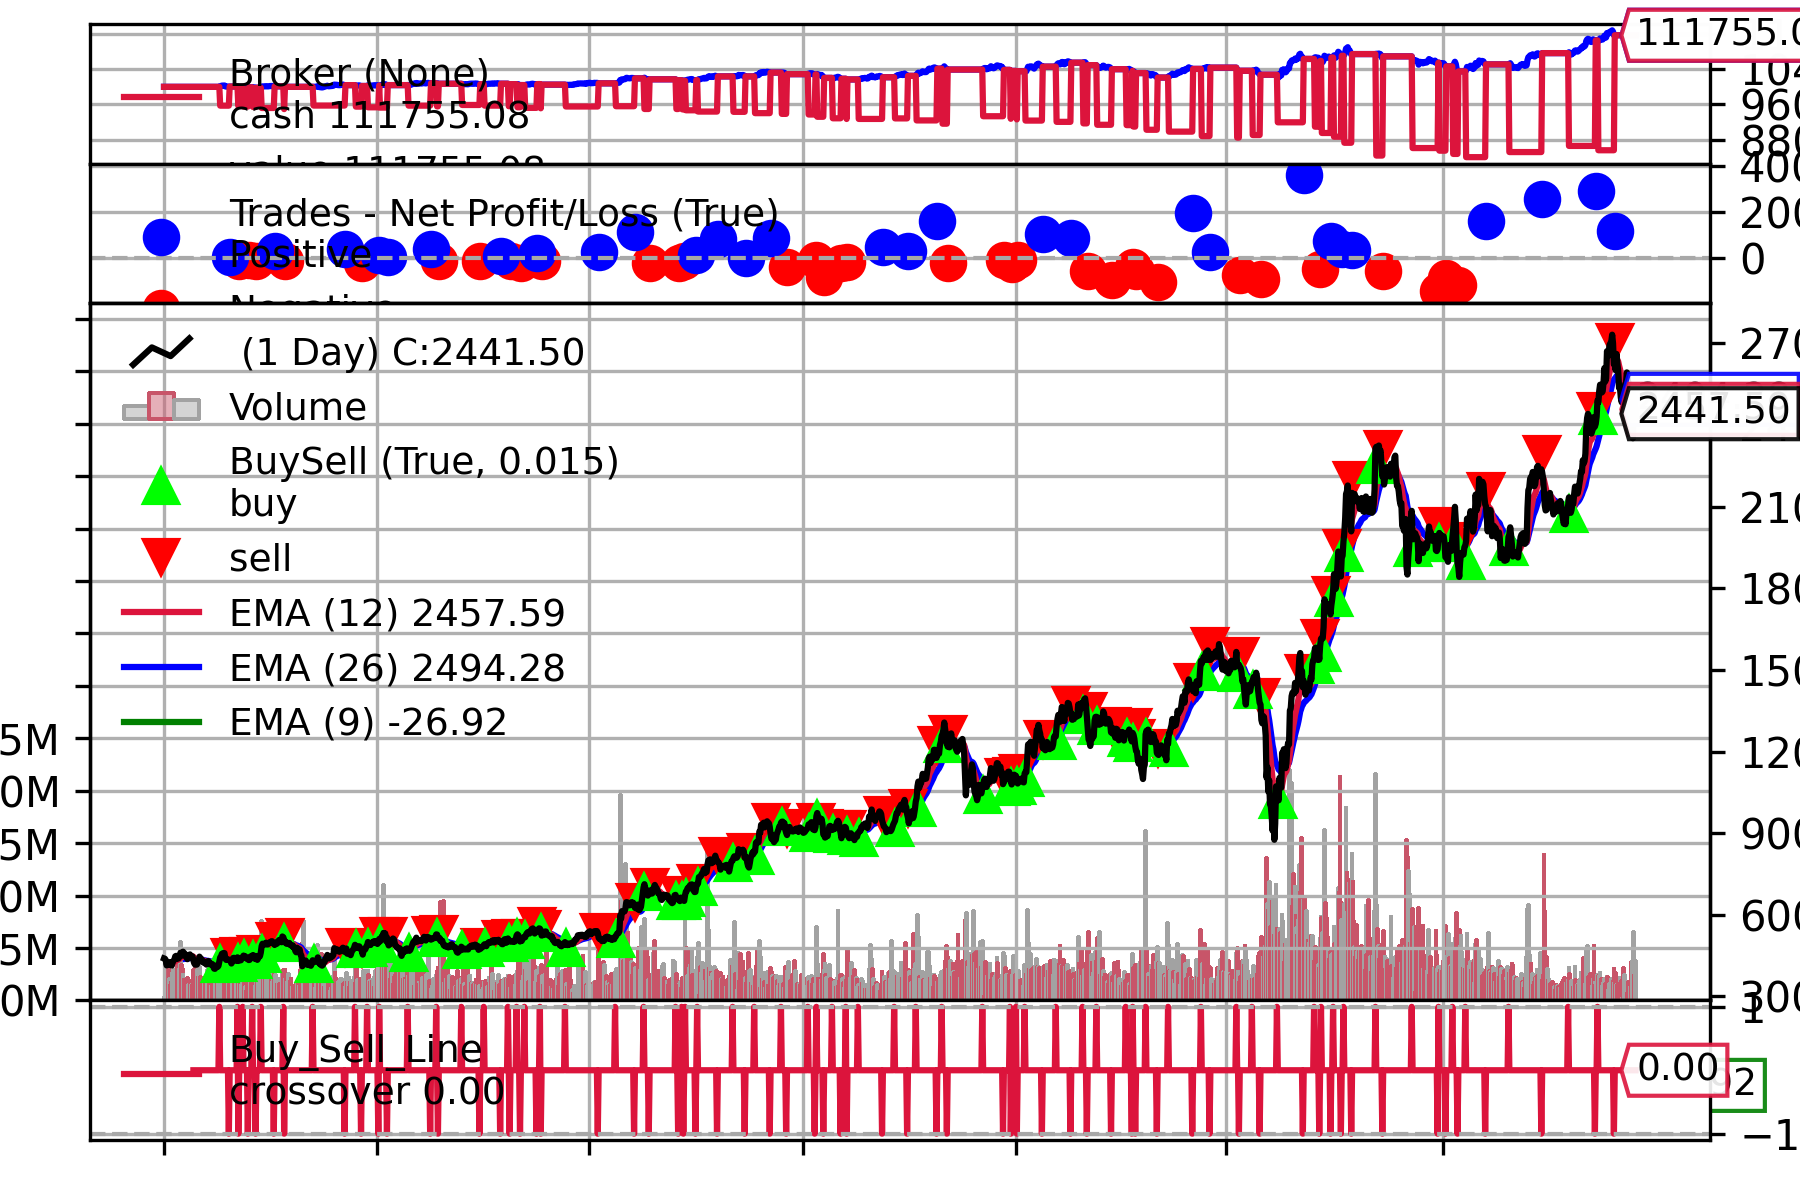

In [35]:
  chart_file = 'result.png'
  cerebro.plot()[0][0].savefig(chart_file, dpi=300)
  Image(open(chart_file, 'rb').read())